<h1> Hyperparameters tuning & Ensembles </h1>

In [5]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics 
import scikitplot as skplt
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<h3> Problem: Predict Diabetes From Medical Records </h3>
    <h4> Dataset: </h4>
    <li> diabetes.csv </li>
    <h4> About the dataset:</h4>
    <li> <a href=https://www.kaggle.com/datasets/mathchi/diabetes-data-set> https://www.kaggle.com/datasets/mathchi/diabetes-data-set</a>
    <h4> Content: </h4>
      <li> Pregnancies: Number of times pregnant </li>
      <li> Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test </li>
      <li> BloodPressure: Diastolic blood pressure (mm Hg) </li>
      <li> SkinThickness: Triceps skin fold thickness (mm) </li>
    <li> Insulin: 2-Hour serum insulin (mu U/ml) </li>
<li> BMI: Body mass index (weight in kg/(height in m)^2)</li>
<li> DiabetesPedigreeFunction: Diabetes pedigree function</li>
<li> Age: Age (years)</li>
<li> Outcome: Class variable (0 or 1)</li>

<h4> I. Load the dataset </h4>

In [6]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'outcome']
data=pd.read_csv("diabetes.csv",names=col_names, header=0)
data.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h4> II. Quick exploration of the dataset </h4>

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   outcome   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
data.describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<b> For bmi, glucose, bp and skin the min value is 0 which is impossible. Missing values may have been filled with 0.
We may want to replace all 0 values with NaN and use imputation techniques to impute the data </b>

In [9]:
['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'outcome']
columns = ['bmi', 'glucose', 'bp', 'skin']

for col in columns:
    data[col] = data[col].map(lambda x:x if x != 0 else None)

In [10]:
data.isnull().sum()

pregnant      0
glucose       5
bp           35
skin        227
insulin       0
bmi          11
pedigree      0
age           0
outcome       0
dtype: int64

Text(0, 0.5, 'Frequency')

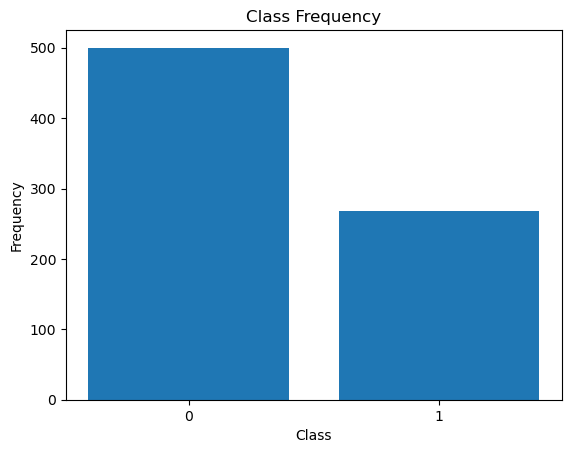

In [11]:
#data[data["glucose"]==1]
label, counts = np.unique(data.outcome, return_counts=True)
plt.bar(label, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.xticks(range(0,2,1))
plt.ylabel('Frequency')
#label, counts 

<h4> III. Train an ensemble for diabetes prediction</h4>

<h5> 1) Split it into training set, a validation set, and a test set : use
30% of data for test, 30% of training for validation </h5>

In [12]:
X = data.iloc[:,:-1] # Features
y = data.outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=0)
X
#data

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
0,6,148.0,72.0,35.0,0,33.6,0.627,50
1,1,85.0,66.0,29.0,0,26.6,0.351,31
2,8,183.0,64.0,NaN,0,23.3,0.672,32
3,1,89.0,66.0,23.0,94,28.1,0.167,21
4,0,137.0,40.0,35.0,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180,32.9,0.171,63
764,2,122.0,70.0,27.0,0,36.8,0.340,27
765,5,121.0,72.0,23.0,112,26.2,0.245,30
766,1,126.0,60.0,NaN,0,30.1,0.349,47


In [13]:
print("Train:", len(X_train), ", Val:", len(X_val),", Test:", len(X_test))

print("Train set: ")
print("Positives: ", len(y_train[y_train==1])/len(X_train))
print("Negatives: ", len(y_train[y_train==0])/len(X_train))

print("Val set: ")
print("Positives: ", len(y_val[y_val==1])/len(X_val))
print("Negatives: ", len(y_val[y_val==0])/len(X_val))

print("Test set: ")
print("Positives: ", len(y_test[y_test==1])/len(X_test))
print("Negatives: ", len(y_test[y_test==0])/len(X_test))

Train: 614 , Val: 154 , Test: 231
Train set: 
Positives:  0.35993485342019543
Negatives:  0.6400651465798045
Val set: 
Positives:  0.3051948051948052
Negatives:  0.6948051948051948
Test set: 
Positives:  0.3203463203463203
Negatives:  0.6796536796536796


<b> 2) using sklearn pipeline, create a pipeline with the followins steps : <br/> </b>
 - Imputation to fill the missing values : you can use the SimpleImputer() method 
 - Standardization for data normalization : you can use the MinMaxScaler() method
 - Classification for prediction : we will test three different models for prediction (SVM, Decision Tree and Logistic Regression) <br/>

<b> 3) fit the pipline and print the scores of the different models</b> <br/>
 - As a first step, use the models with the default parameters
 - for the score: since we are dealing with an umbalanced dataset we may use f1_score
 

# imputation

In [14]:
from sklearn.impute import SimpleImputer

# Remplacer les valeurs aberrantes par la médiane
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data)


In [15]:
data_imputed

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

# normalisation

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [17]:
scaler=MinMaxScaler()

In [18]:
data_normalisation=scaler.fit_transform(data_imputed)
data_normalisation

array([[0.35294118, 0.67096774, 0.48979592, ..., 0.23441503, 0.48333333,
        1.        ],
       [0.05882353, 0.26451613, 0.42857143, ..., 0.11656704, 0.16666667,
        0.        ],
       [0.47058824, 0.89677419, 0.40816327, ..., 0.25362938, 0.18333333,
        1.        ],
       ...,
       [0.29411765, 0.49677419, 0.48979592, ..., 0.07130658, 0.15      ,
        0.        ],
       [0.05882353, 0.52903226, 0.36734694, ..., 0.11571307, 0.43333333,
        1.        ],
       [0.05882353, 0.31612903, 0.46938776, ..., 0.10119556, 0.03333333,
        0.        ]])

In [19]:
data_normalisation=pd.DataFrame(data_normalisation,columns=['pregnant','glucose','bp','skin','insulin','bmi','pedigree','age','outcome'])

In [20]:
data_normalisation

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,outcome
0,0.352941,0.670968,0.489796,0.304348,0.000000,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.239130,0.000000,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,0.239130,0.000000,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.173913,0.111111,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.304348,0.198582,0.509202,0.943638,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.212766,0.300613,0.039710,0.700000,0.0
764,0.117647,0.503226,0.469388,0.217391,0.000000,0.380368,0.111870,0.100000,0.0
765,0.294118,0.496774,0.489796,0.173913,0.132388,0.163599,0.071307,0.150000,0.0
766,0.058824,0.529032,0.367347,0.239130,0.000000,0.243354,0.115713,0.433333,1.0


# Classification

In [21]:
X = data_normalisation.iloc[:,:-1] # Features
y = data_normalisation.outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
580,0.000000,0.690323,0.673469,0.423913,0.000000,0.488753,0.125107,0.000000
418,0.058824,0.251613,0.448980,0.239130,0.000000,0.000000,0.233134,0.100000
764,0.117647,0.503226,0.469388,0.217391,0.000000,0.380368,0.111870,0.100000
363,0.235294,0.658065,0.551020,0.239130,0.000000,0.415133,0.188728,0.766667
757,0.000000,0.509677,0.489796,0.239130,0.000000,0.370143,0.076857,0.516667
...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.212766,0.300613,0.039710,0.700000
192,0.411765,0.741935,0.428571,0.239130,0.000000,0.249489,0.130231,0.250000
629,0.235294,0.322581,0.418367,0.163043,0.000000,0.132924,0.029889,0.000000
559,0.647059,0.264516,0.510204,0.239130,0.000000,0.243354,0.094791,0.233333


<h2 style="color:green;">Pipline</h2>

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Define the steps in the pipeline
steps = [
    ('imputer', SimpleImputer()),  # Step 1: Imputation to fill missing values
    ('scaler', MinMaxScaler()),    # Step 2: Standardization for data normalization
    ('classifier', None)           # Step 3: Classifier (will be replaced by different models)
]

# Create an empty pipeline
pipeline = Pipeline(steps)

# Define the three different models for classification
svm_model = SVC()
decision_tree_model = DecisionTreeClassifier()
logistic_regression_model = LogisticRegression()

# Create a list of tuples, each containing the model name and the corresponding model object
models = [
    ('SVM', svm_model),
    ('Decision Tree', decision_tree_model),
    ('Logistic Regression', logistic_regression_model)
]

# Iterate over each model and fit it into the pipeline
for model_name, model_object in models:
    pipeline.steps[-1] = ('classifier', model_object)  # Replace the classifier in the pipeline
    pipeline.fit(X_train, y_train)  # Assuming X_train and y_train are your training data
    accuracy = pipeline.score(X_test, y_test)  # Assuming X_test and y_test are your test data
    print(f"Accuracy of {model_name}: {accuracy}")


Accuracy of SVM: 0.7575757575757576
Accuracy of Decision Tree: 0.7316017316017316
Accuracy of Logistic Regression: 0.7705627705627706


<h4> Tuning classification models</h4>
<b> 4) Use GridSearchCV to test different values for the used models hyperparameters <br/> </b>

 - you can use <b>estimator.get_params().keys() </b> to find the parameters of an estimator
 - you can also test different strategies for imputation (e.g., "mean", "median", "most_frequent", "constant")
 - for each model, keep the best estimator
 - compare with the scores of default models
    

In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Load the dataset


# Split the data


# Define models and hyperparameter grids
models = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestRegressor()
}

param_grids = {
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['linear', 'rbf']
    },
    'Decision Tree': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

imputation_strategies = ['mean', 'median', 'most_frequent', 'constant']

# Function to create pipeline and perform GridSearchCV
def tune_model(model_name, model, param_grid, impute_strategy):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=impute_strategy)),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    return best_model, best_score

# Tuning models and comparing with default models
best_models = {}
default_scores = {}
tuned_scores = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    
    # Get default model score
    default_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', model)
    ])
    default_model.fit(X_train, y_train)
    y_pred_default = default_model.predict(X_test)
    default_scores[model_name] = accuracy_score(y_test, y_pred_default)
    
    # Tune model with different imputation strategies
    best_score = 0
    for strategy in imputation_strategies:
        tuned_model, score = tune_model(model_name, model, param_grids[model_name], strategy)
        if score > best_score:
            best_models[model_name] = tuned_model
            best_score = score
            tuned_scores[model_name] = best_score

# Display results
print("\nDefault Model Scores:")
for model_name, score in default_scores.items():
    print(f"{model_name}: {score:.4f}")

print("\nTuned Model Scores:")
for model_name, score in tuned_scores.items():
    print(f"{model_name}: {score:.4f}")

# Test the best models on the test set
print("\nTesting Best Models on Test Set:")
for model_name, model in best_models.items():
    y_pred_tuned = model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred_tuned)
    print(f"{model_name}: {test_score:.4f}")


Tuning SVM...
Tuning Decision Tree...
Tuning Logistic Regression...
Tuning Random Forest...


ValueError: Classification metrics can't handle a mix of binary and continuous targets

<h4> Ensembling </h4>
<b> 5) using the best estimators, train a voting ensemble <br/> </b>

- use VotingClassifier from sklearn.ensemble 
- test different voting strategies (hard vs soft) and different weight combination
- compare the scores of the ensembles with that of weak learners

<b> 6) Implement and train a stacking ensemble </b> <br/>
 - use the training set to train the level 0 learner and the validation set to train the meta-learner
 - use StratifiedKFold for cross validation : 
 
     - for each fold, level 0 learner will be fit to the train set and used for prediction on the validation set
     
     - fold predictions are stored in a new dataset
 
 - Use the new dataset for training a voting, a logistic regression model,....
 - compare the results

In [269]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
